<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [149]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [150]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [151]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [152]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(500, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# # model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10))
model.add(layers.Softmax())

In [153]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [154]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=128,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/20
469/469 [==============================] - 7s 14ms/step - loss: 0.5667 - accuracy: 0.8051 - val_loss: 0.4668 - val_accuracy: 0.8332
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 0.4227 - accuracy: 0.8505 - val_loss: 0.4307 - val_accuracy: 0.8435
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.3885 - accuracy: 0.8605 - val_loss: 0.4072 - val_accuracy: 0.8567
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 0.3616 - accuracy: 0.8700 - val_loss: 0.4026 - val_accuracy: 0.8561
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.3439 - accuracy: 0.8773 - val_loss: 0.3899 - val_accuracy: 0.8607
Epoch 6/20
469/469 [==============================] - 7s 16ms/step - loss: 0.3282 - accuracy: 0.8827 - val_loss: 0.3696 - val_accuracy: 0.8679
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.3174 - accuracy: 0.8865 - val_loss: 0.3621 - val_accuracy: 0.8724

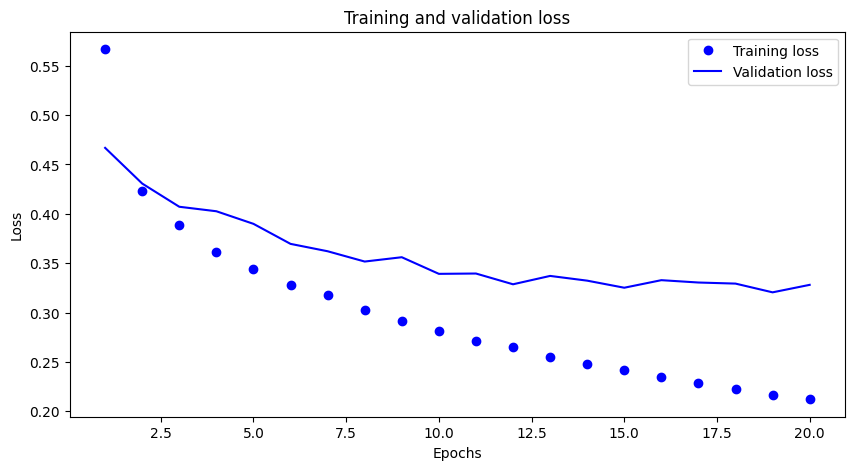

<Figure size 640x480 with 0 Axes>

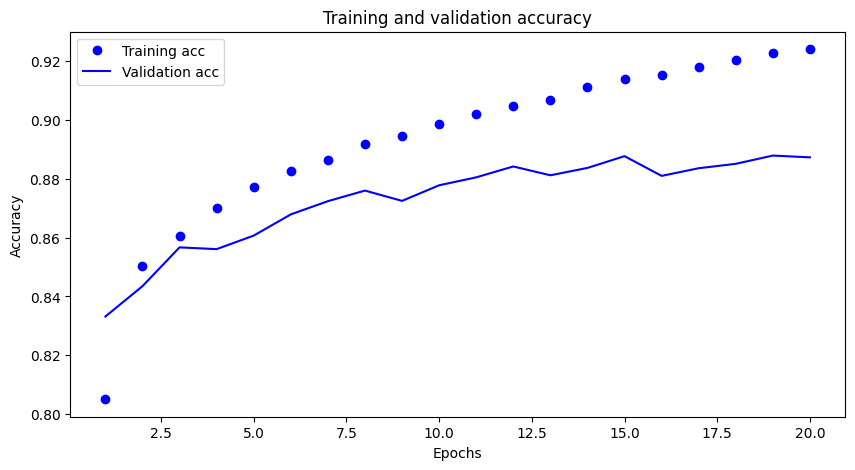

In [155]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [156]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [157]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [158]:
predictions[0]

array([0.08540711, 0.08540711, 0.08540711, 0.08540712, 0.08540725,
       0.08561469, 0.0854076 , 0.08568185, 0.08540725, 0.23085281],
      dtype=float32)